In [30]:
import keras, os
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models, losses
from keras.layers import Input, Dense, Conv2D, MaxPool2D , Flatten, MaxPooling2D, GlobalAveragePooling2D ,AveragePooling2D, Dropout, Activation, BatchNormalization

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Read Dataset**

In [5]:
from keras_preprocessing.image import ImageDataGenerator

train_DataGenerator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

TRAIN_AUG_DIR = r"/content/drive/MyDrive/New_Train"

labels=['Basketball','Football','Rowing','Swimming','Tennis','Yoga']

train_d = train_DataGenerator.flow_from_directory(
      TRAIN_AUG_DIR,
      classes=labels,
      color_mode="rgb",
      batch_size=16,
      target_size=(224,224),
      class_mode="categorical",
      subset="training")

valid_d = train_DataGenerator.flow_from_directory(
    TRAIN_AUG_DIR,
    classes=labels,
    color_mode="rgb",
    batch_size=16,
    target_size=(224,224),
    class_mode="categorical",
    subset="validation"
)

Found 4686 images belonging to 6 classes.
Found 1168 images belonging to 6 classes.


# **History Plot**

In [98]:
def history_plot(history):
  fig=plt.figure(figsize=(15 , 7))
  # plt.plot(history.history["acc"])
  # plt.plot(history.history['val_acc'])
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title("model accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
  plt.show()

# **Inception Model**

In [7]:
def Convolutional_with_Batch_Normalisation(prev_layer , num_kernels , filter_Size , strides =(1,1) , padding = 'same'):
  x = Conv2D(filters=num_kernels, kernel_size = filter_Size, strides=strides , padding=padding)(prev_layer)
  x = BatchNormalization(axis=3)(x)
  x = Activation(activation='relu')(x)
  return x

In [8]:
def Stem(prev_layer):
  x = Convolutional_with_Batch_Normalisation(prev_layer, num_kernels = 32, filter_Size=(3,3) , strides=(2,2))
  x = Convolutional_with_Batch_Normalisation(x, num_kernels = 32, filter_Size=(3,3))
  x = Convolutional_with_Batch_Normalisation(x, num_kernels = 64, filter_Size=(3,3))
  x = MaxPool2D(pool_size=(3,3) , strides=(2,2)) (x)
  x = Convolutional_with_Batch_Normalisation(x, num_kernels = 80, filter_Size=(1,1))
  x = Convolutional_with_Batch_Normalisation(x, num_kernels = 192, filter_Size=(3,3))
  x = MaxPool2D(pool_size=(3,3) , strides=(2,2)) (x)
  return x

In [10]:
def Inception_A(prev_layer  , num_kernels):   
  branch1 = Convolutional_with_Batch_Normalisation(prev_layer, num_kernels = 64, filter_Size = (1,1))
  branch1 = Convolutional_with_Batch_Normalisation(branch1, num_kernels=96, filter_Size=(3,3))
  branch1 = Convolutional_with_Batch_Normalisation(branch1, num_kernels=96, filter_Size=(3,3))
  
  branch2 = Convolutional_with_Batch_Normalisation(prev_layer, num_kernels=48, filter_Size=(1,1))
  branch2 = Convolutional_with_Batch_Normalisation(branch2, num_kernels=64, filter_Size=(3,3))
  
  branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding='same') (prev_layer)
  branch3 = Convolutional_with_Batch_Normalisation(branch3, num_kernels = num_kernels, filter_Size = (1,1))
  
  branch4 = Convolutional_with_Batch_Normalisation(prev_layer, num_kernels=64, filter_Size=(1,1))
  
  output = concatenate([branch1 , branch2 , branch3 , branch4], axis=3)
  
  return output

In [11]:
def Inception_B(prev_layer , num_kernels):
  branch1 = Convolutional_with_Batch_Normalisation(prev_layer, num_kernels = num_kernels, filter_Size = (1,1))
  branch1 = Convolutional_with_Batch_Normalisation(branch1, num_kernels = num_kernels, filter_Size = (7,1))
  branch1 = Convolutional_with_Batch_Normalisation(branch1, num_kernels = num_kernels, filter_Size = (1,7))
  branch1 = Convolutional_with_Batch_Normalisation(branch1, num_kernels = num_kernels, filter_Size = (7,1))    
  branch1 = Convolutional_with_Batch_Normalisation(branch1, num_kernels = 192, filter_Size = (1,7))
  
  branch2 = Convolutional_with_Batch_Normalisation(prev_layer, num_kernels = num_kernels, filter_Size = (1,1))
  branch2 = Convolutional_with_Batch_Normalisation(branch2, num_kernels = num_kernels, filter_Size = (1,7))
  branch2 = Convolutional_with_Batch_Normalisation(branch2, num_kernels = 192, filter_Size = (7,1))
  
  branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding ='same') (prev_layer)
  branch3 = Convolutional_with_Batch_Normalisation(branch3, num_kernels = 192, filter_Size = (1,1))
  
  branch4 = Convolutional_with_Batch_Normalisation(prev_layer, num_kernels = 192, filter_Size = (1,1))
  
  output = concatenate([branch1 , branch2 , branch3 , branch4], axis = 3)
  
  return output

In [12]:
def Inception_C(prev_layer):
  branch1 = Convolutional_with_Batch_Normalisation(prev_layer, num_kernels = 448, filter_Size = (1,1))
  branch1 = Convolutional_with_Batch_Normalisation(branch1, num_kernels = 384, filter_Size = (3,3))
  branch1_1 = Convolutional_with_Batch_Normalisation(branch1, num_kernels = 384, filter_Size = (1,3))    
  branch1_2 = Convolutional_with_Batch_Normalisation(branch1, num_kernels = 384, filter_Size = (3,1))
  branch1 = concatenate([branch1_1 , branch1_2], axis = 3)
  
  branch2 = Convolutional_with_Batch_Normalisation(prev_layer, num_kernels = 384, filter_Size = (1,1))
  branch2_1 = Convolutional_with_Batch_Normalisation(branch2, num_kernels = 384, filter_Size = (1,3))
  branch2_2 = Convolutional_with_Batch_Normalisation(branch2, num_kernels = 384, filter_Size = (3,1))
  branch2 = concatenate([branch2_1 , branch2_2], axis = 3)
  
  branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding='same')(prev_layer)
  branch3 = Convolutional_with_Batch_Normalisation(branch3, num_kernels = 192, filter_Size = (1,1))
  
  branch4 = Convolutional_with_Batch_Normalisation(prev_layer, num_kernels = 320, filter_Size = (1,1))
  
  output = concatenate([branch1 , branch2 , branch3 , branch4], axis = 3)
  
  return output

In [13]:
def Reduction_A(prev_layer):
  branch1 = Convolutional_with_Batch_Normalisation(prev_layer, num_kernels = 64, filter_Size = (1,1))
  branch1 = Convolutional_with_Batch_Normalisation(branch1, num_kernels = 96, filter_Size = (3,3))
  branch1 = Convolutional_with_Batch_Normalisation(branch1, num_kernels = 96, filter_Size = (3,3) , strides=(2,2))
  
  branch2 = Convolutional_with_Batch_Normalisation(prev_layer, num_kernels = 384, filter_Size=(3,3) , strides=(2,2))
  
  branch3 = MaxPool2D(pool_size=(3,3) , strides=(2,2) , padding='same')(prev_layer)
  
  output = concatenate([branch1 , branch2 , branch3], axis = 3)
  
  return output

In [14]:
def Reduction_B(prev_layer):
  branch1 = Convolutional_with_Batch_Normalisation(prev_layer, num_kernels = 192, filter_Size = (1,1))
  branch1 = Convolutional_with_Batch_Normalisation(branch1, num_kernels = 192, filter_Size = (1,7))
  branch1 = Convolutional_with_Batch_Normalisation(branch1, num_kernels = 192, filter_Size = (7,1))
  branch1 = Convolutional_with_Batch_Normalisation(branch1, num_kernels = 192, filter_Size = (3,3) , strides=(2,2) , padding = 'valid')
  
  branch2 = Convolutional_with_Batch_Normalisation(prev_layer, num_kernels = 192, filter_Size = (1,1))
  branch2 = Convolutional_with_Batch_Normalisation(branch2, num_kernels = 320, filter_Size = (3,3) , strides=(2,2) , padding='valid')

  branch3 = MaxPool2D(pool_size=(3,3) , strides=(2,2) )(prev_layer)
  
  output = concatenate([branch1 , branch2 , branch3], axis = 3)
  
  return output

In [15]:
def auxiliary_classifier(prev_Layer):
  x = AveragePooling2D(pool_size=(5,5) , strides=(3,3)) (prev_Layer)
  x = Convolutional_with_Batch_Normalisation(x, num_kernels = 128, filter_Size = (1,1))
  x = Flatten()(x)
  x = Dense(units = 768, activation='relu') (x)
  x = Dropout(rate = 0.2) (x)
  x = Dense(units = 6, activation='softmax') (x)
  return x

In [16]:
def InceptionV3():
  input_layer = Input(shape=(224 , 224 , 3))
    
  x = Stem(input_layer)
  
  x = Inception_A(prev_layer = x ,num_kernels = 32)
  x = Inception_A(prev_layer = x ,num_kernels = 64)
  x = Inception_A(prev_layer = x ,num_kernels = 64)
  
  x = Reduction_A(prev_layer = x )
  
  x = Inception_B(prev_layer = x  , num_kernels = 128)
  x = Inception_B(prev_layer = x , num_kernels = 160)
  x = Inception_B(prev_layer = x , num_kernels = 160)
  x = Inception_B(prev_layer = x , num_kernels = 192)
  
  Aux = auxiliary_classifier(prev_Layer = x)
  
  x = Reduction_B(prev_layer = x)
  
  x = Inception_C(prev_layer = x)
  x = Inception_C(prev_layer = x)
  
  x = GlobalAveragePooling2D()(x)
  x = Dense(units=2048, activation='relu') (x)
  x = Dropout(rate = 0.2) (x)
  x = Dense(units=6, activation='softmax') (x)
  
  model = Model(inputs = input_layer , outputs = [x , Aux])    
  return model

In [53]:
from tensorflow.keras.optimizers import RMSprop
model_inception_v3 = InceptionV3()
model_inception_v3.compile( optimizer = RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
# model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

In [52]:
from tensorflow.keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(restore_best_weights=True,patience=3)

In [54]:
history = model_inception_v3.fit(train_d,validation_data=valid_d,epochs=30,callbacks = [early_stopping])

Epoch 1/30
293/293 [==============================] - 85s 220ms/step - loss: 2.3652 - dense_11_loss: 1.2442 - dense_9_loss: 1.1211 - dense_11_accuracy: 0.5625 - dense_9_accuracy: 0.6058 - val_loss: 6.4259 - val_dense_11_loss: 2.8677 - val_dense_9_loss: 3.5582 - val_dense_11_accuracy: 0.3878 - val_dense_9_accuracy: 0.2851
Epoch 2/30
293/293 [==============================] - 62s 211ms/step - loss: 1.7724 - dense_11_loss: 0.9355 - dense_9_loss: 0.8369 - dense_11_accuracy: 0.6765 - dense_9_accuracy: 0.7108 - val_loss: 2.0449 - val_dense_11_loss: 1.1873 - val_dense_9_loss: 0.8577 - val_dense_11_accuracy: 0.5942 - val_dense_9_accuracy: 0.7072
Epoch 3/30
293/293 [==============================] - 63s 214ms/step - loss: 1.5247 - dense_11_loss: 0.8178 - dense_9_loss: 0.7069 - dense_11_accuracy: 0.7138 - dense_9_accuracy: 0.7516 - val_loss: 1.6815 - val_dense_11_loss: 0.9206 - val_dense_9_loss: 0.7609 - val_dense_11_accuracy: 0.7457 - val_dense_9_accuracy: 0.7765
Epoch 4/30
293/293 [===========

In [71]:
from tensorflow.keras.models import load_model
model_inception_v3.save('model_inception_v3_.h5')

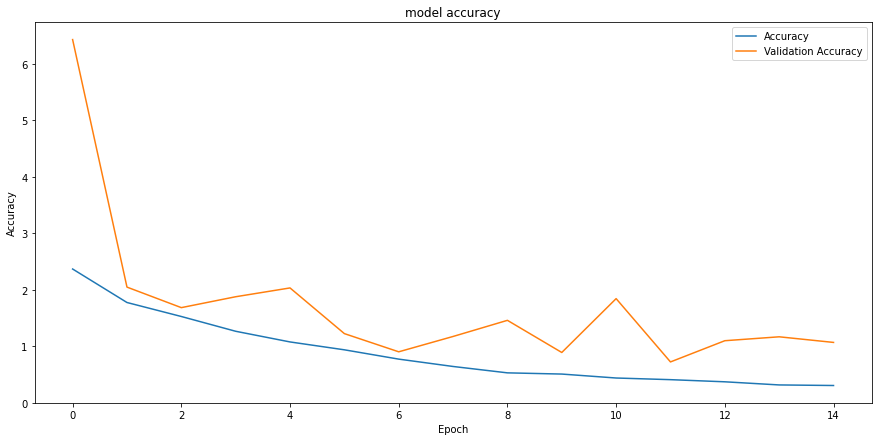

In [99]:
history_plot(history)

# **Save Model**

In [ ]:
# from keras.models import model_from_json
# import os

# model_json = model.to_json()

# with open("model.json", "w") as json_file:
#     json_file.write(model_json)

# model.save_weights(os.path.join(os.getcwd(), 'model.h5'))